# Improving Beta Estimate

## Setup

### here I just create a Linear inversion to get dmis and reg object

/Users/thibautastic/GITHUB/simpeg-private/SimPEG/simulation.py:531: UserWarning: G has not been implemented for the simulation
  warnings.warn("G has not been implemented for the simulation")


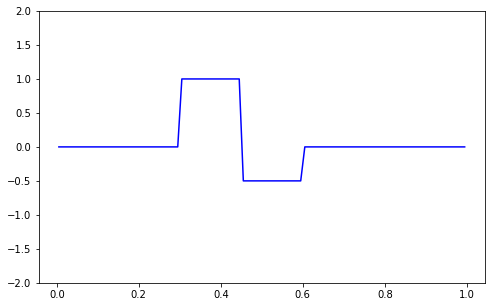

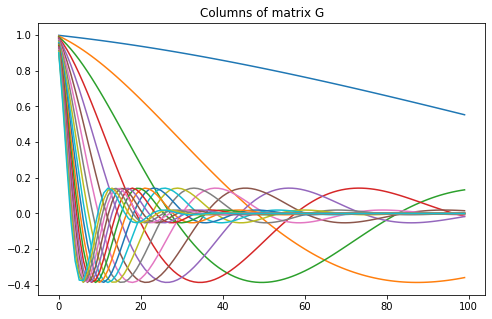

In [2]:
"""
Linear Least-Squares Inversion
==============================

Here we demonstrate the basics of inverting data with SimPEG by considering a
linear inverse problem. We formulate the inverse problem as a least-squares
optimization problem. For this tutorial, we focus on the following:

    - Defining the forward problem
    - Defining the inverse problem (data misfit, regularization, optimization)
    - Specifying directives for the inversion
    - Recovering a set of model parameters which explains the observations


"""

#########################################################################
# Import Modules
# --------------
#


import numpy as np
import matplotlib.pyplot as plt

from discretize import TensorMesh

from SimPEG import (
    simulation,
    maps,
    data_misfit,
    directives,
    optimization,
    regularization,
    inverse_problem,
    inversion,
)

# sphinx_gallery_thumbnail_number = 3

#############################################
# Defining the Model and Mapping
# ------------------------------
#
# Here we generate a synthetic model and a mappig which goes from the model
# space to the row space of our linear operator.
#

nParam = 100  # Number of model paramters

# A 1D mesh is used to define the row-space of the linear operator.
mesh = TensorMesh([nParam])

# Creating the true model
true_model = np.zeros(mesh.nC)
true_model[mesh.vectorCCx > 0.3] = 1.0
true_model[mesh.vectorCCx > 0.45] = -0.5
true_model[mesh.vectorCCx > 0.6] = 0

# Mapping from the model space to the row space of the linear operator
model_map = maps.IdentityMap(mesh)

# Plotting the true model
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.plot(mesh.vectorCCx, true_model, "b-")
ax.set_ylim([-2, 2])

#############################################
# Defining the Linear Operator
# ----------------------------
#
# Here we define the linear operator with dimensions (nData, nParam). In practive,
# you may have a problem-specific linear operator which you would like to construct
# or load here.
#

# Number of data observations (rows)
nData = 20

# Create the linear operator for the tutorial. The columns of the linear operator
# represents a set of decaying and oscillating functions.
jk = np.linspace(1.0, 60.0, nData)
p = -0.25
q = 0.25


def g(k):
    return np.exp(p * jk[k] * mesh.vectorCCx) * np.cos(
        np.pi * q * jk[k] * mesh.vectorCCx
    )


G = np.empty((nData, nParam))

for i in range(nData):
    G[i, :] = g(i)

# Plot the columns of G
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
for i in range(G.shape[0]):
    ax.plot(G[i, :])

ax.set_title("Columns of matrix G")


#############################################
# Defining the Simulation
# -----------------------
#
# The simulation defines the relationship between the model parameters and
# predicted data.
#

sim = simulation.LinearSimulation(mesh, G=G, model_map=model_map)

#############################################
# Predict Synthetic Data
# ----------------------
#
# Here, we use the true model to create synthetic data which we will subsequently
# invert.
#

# Standard deviation of Gaussian noise being added
std = 0.01
np.random.seed(1)

# Create a SimPEG data object
data_obj = sim.make_synthetic_data(true_model, relative_error=std, add_noise=True)

#######################################################################
# Define the Inverse Problem
# --------------------------
#
# The inverse problem is defined by 3 things:
#
#     1) Data Misfit: a measure of how well our recovered model explains the field data
#     2) Regularization: constraints placed on the recovered model and a priori information
#     3) Optimization: the numerical approach used to solve the inverse problem
#

# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.
dmis = data_misfit.L2DataMisfit(simulation=sim, data=data_obj)

# Define the regularization (model objective function).
reg = regularization.Tikhonov(mesh, alpha_s=1.0, alpha_x=1.0)


# Estimate DM and Reg Eigenvalue by hand

In [45]:
# Reg matrix
WW = reg.deriv2(starting_model).toarray()
#DM matrix
DD = G.T.dot(((np.diag(dmis.W.diagonal())**2)).dot(G))

In [46]:
# sanity check: check there are the same operator
xtest = np.ones(100)
print(np.all(np.isclose(WW.dot(xtest),reg.deriv2(starting_model, xtest),atol=1e-14,)))
print(np.all(np.isclose(DD.dot(xtest),dmis.deriv2(starting_model, xtest),atol=1e-14,)))

True
True


In [47]:
w = np.linalg.eigvals(WW)
print('highest eigenvalue for Reg: ', w.max())

highest eigenvalue for Reg:  399.9113120731457


In [48]:
d = np.linalg.eigvals(DD)
print('highest eigenvalue for dmis: ', d.real.max())

highest eigenvalue for dmis:  700124411.0424484


In [49]:
print('the ratio is thus: ', d.real.max()/w.max())

the ratio is thus:  1750699.1923108997


#### but at http://docs.simpeg.xyz/content/tutorials/02-linear_inversion/plot_inv_1_inversion_lsq.html#sphx-glr-content-tutorials-02-linear-inversion-plot-inv-1-inversion-lsq-py

#### We see the computed ratio is (taking into account the beta_ratio factor of 1e-2): 6.04e+04

### WE ARE SEVERAL ORDER OF MAGNITUDE OFF.

### SimPEG directives estimate eigenvalues by a single iteration of a Rayleigh quotient algorithm

### Doing a single iteration of Rayleigh gives a terrible result, which is highly dependent of the starting random vector and can be order of magnitude off.

## Demonstration

In [50]:
# This piece of code mimic the BetaEstimate_byEig directives
# Fix the seed for random vector for consistent result
np.random.seed(1)
x0 = np.random.rand(100)

t, b = 0, 0
t = x0.dot(DD.dot(x0))
b = x0.dot(WW.dot(x0))
ratio = (t / b)
print(ratio)

60368.98580910517


### We found the same estimate as on the webpage.

### Now let show why this is a terrible estimate: let's run it with different seeds many times to see how speadout it is:

<function matplotlib.pyplot.show(*args, **kw)>

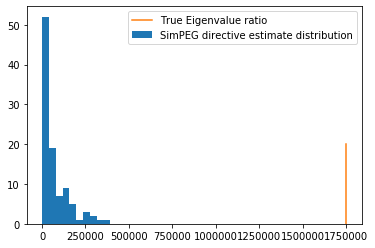

In [55]:
# This piece of code mimic the BetaEstimate_byEig directives
# np.random.seed(1) #disable the seed
n_run = 100
ratio = []
for i in range(n_run):
    x0 = np.random.rand(100)
    t, b = 0, 0
    t = x0.dot(DD.dot(x0))
    b = x0.dot(WW.dot(x0))
    ratio.append(t / b)
plt.hist(ratio, label='SimPEG directive estimate distribution')
plt.plot(d.real.max()/w.max()*np.ones(2),[0,20],label='True Eigenvalue ratio')
plt.gca().legend()
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

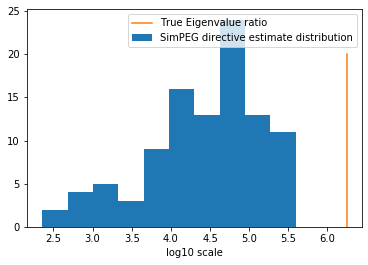

In [61]:
#Ok let see it on log scale
plt.hist(np.log10(ratio), label='SimPEG directive estimate distribution')
plt.plot(np.log10(d.real.max()/w.max())*np.ones(2),[0,20],label='True Eigenvalue ratio')
plt.gca().legend()
plt.gca().set_xlabel('log10 scale')
plt.show

### SimPEG estimate (blue) span many order of magnitude, and is off the true value by anoter order of magnitude

## Solution: rewrite BetaEstimate to run several iteration of Rayleight

In [138]:
# This mimic the new BetaEstimate, and run it several times to see how spreadout it is

# np.random.seed(1) #disable the seed
n_run = 1000
max_rayleigh_iter = 10
ratio = np.zeros([n_run,max_rayleigh_iter]) #number iteration from 1 to max
for i in range(n_run):
    ##initialize for both data misfit and reg. eig. individually
    x0 = np.random.rand(100)
    x0 = x0 / np.linalg.norm(x0)
    x2 = np.random.rand(100)
    x2 = x2 / np.linalg.norm(x2)
    t, b = 0, 0
    
    for j in range(max_rayleigh_iter):
        #dmis eig.
        x1 = DD.dot(x0)
        x0 = x1 / np.linalg.norm(x1)
        t = x0.dot(DD.dot(x0))
        ##reg eig.
        x3 = WW.dot(x2)
        x2 = x3 / np.linalg.norm(x3)
        b = x2.dot(WW.dot(x2))
        
        ratio[i,j] = (t / b)

<function matplotlib.pyplot.show(*args, **kw)>

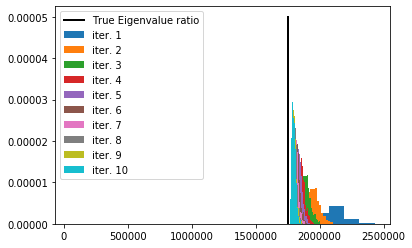

In [140]:
for j in range(max_rayleigh_iter):
    #if np.mod(j,10) == 0:
        plt.hist(ratio[:,j], bins=20, label = 'iter. {}'.format(j+1),density=True)
plt.plot(d.real.max()/w.max()*np.ones(2),[0,0.00005],label='True Eigenvalue ratio', linewidth=2,c='k')
plt.gca().legend()
plt.show

/Users/thibautastic/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


<function matplotlib.pyplot.show(*args, **kw)>

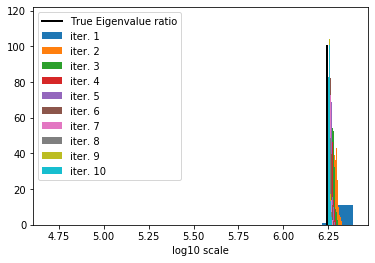

In [141]:
for j in range(max_rayleigh_iter):
    #if np.mod(j,10) == 0:
        plt.hist(np.log10(ratio[:,j]), label = 'iter. {}'.format(j+1),normed=True, bins=20)
plt.plot(np.log10(d.real.max()/w.max())*np.ones(2),[0,100],label='True Eigenvalue ratio', linewidth=2,c='k')
plt.gca().legend()
plt.gca().set_xlabel('log10 scale')
plt.show

### We see that the estimator is getting closer to the true value at each iteration, and the spread is getting tighter as well.

## PS: even just having 2 different random vector for initialization, rather than a shared one, reduce the spread of the estimation and is more precise.

## Personal default recommendation: 4 rayleigh iterations